In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.optimizers import Adam, SGD
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import tabulate

from bunch import bunchify

# apps
from helpers.model_adam import Model
from helpers.evaluations import Evaluation
print("import several libraries that are used as modeling deep lstm, including hard, pandas, numpy, and sklearn processing. \n** if this text appears, it means the library has been successfully installed")

Using TensorFlow backend.


import several libraries that are used as modeling deep lstm, including hard, pandas, numpy, and sklearn processing. 
** if this text appears, it means the library has been successfully installed


# Read Datasets
> **Notes**
>
> read the dataset of USD and JPY exchange rates against the rupiah, from 01-01-2014 to 01-01-2021

## USD-IDR


In [2]:
usd = pd.read_csv('datasets-usd.csv', index_col='Date')
print(f"Number of row and columns: {usd.shape}")
usd.head()

Number of row and columns: (1809, 4)


,Price,Open,High,Low
Date,,,,
2014-01-01,12170.0,12170.0,12170.0,12170.0
2014-01-02,12160.0,12195.0,12260.0,12150.0
2014-01-03,12170.0,12160.0,12245.0,12160.0
2014-01-06,12180.0,12195.0,12245.0,12180.0
2014-01-07,12237.5,12197.5,12277.5,12197.5


## JPY-IDR

In [3]:
jpy = pd.read_csv('dataset-jpy.csv', index_col='Date')
print(f"Number of row and column: {jpy.shape}")
jpy.head()

Number of row and column: (1828, 4)


,Price,Open,High,Low
Date,,,,
2014-01-01,115.64,115.48,115.71,115.33
2014-01-02,116.07,115.52,116.45,115.19
2014-01-03,116.07,115.90,117.58,115.84
2014-01-06,116.87,115.91,117.48,115.84
2014-01-07,116.97,116.75,117.64,116.43


# Data Single Fitur Configuration

Pada tahap ini data yang diproses hanya fitur data ***Price*** saja. fitur  ***Open***, ***High***, dan ***Low*** diabaikan.

> **Notes**
>
> perform the process of sharing training and test data, then the data will be normalized in standard form. 

## Data spliting (training & testing)

> **Notes**
> Pembagian data training dan testing menggunakan rasio 80% awal untuk training dan 20% terakhir sebagai testing

In [4]:
# split function

def split(data, n_train=0.8, n_test=0.2):
    train_set = data.Price.iloc[:round(n_train*len(data))].values
    test_set = data.Price.iloc[round( n_train*len(data) ):].values
    return train_set, test_set

In [5]:
datasets={
    "usd": {},
    "jpy": {}
}
datasets["usd"]["train_set"], datasets["usd"]["test_set"] = split(usd)
datasets["jpy"]["train_set"], datasets["jpy"]["test_set"] = split(jpy)

## Scaling data with MinMaxFunction [-1, 1]

\begin{equation}
X\_std = \frac{({X} - {X.min(axis=0)})} {(X.max(axis=0) - X.min(axis=0))}\\
\\
X\_scaled = X\_std * (max - min) + min\\
\end{equation}


In [6]:
# scaling data with MinMaxFunction
scaler_usd = MinMaxScaler(feature_range=(-1,1))
scaler_jpy = MinMaxScaler(feature_range=(-1,1))
# transform dataset to (len(data), 1)
datasets["usd"]["train_set"] = datasets["usd"]["train_set"].reshape(
    len(datasets["usd"]["train_set"]), 1
)
datasets["jpy"]["train_set"] = datasets["jpy"]["train_set"].reshape(
    len(datasets["jpy"]["train_set"]), 1
)

datasets["usd"]["test_set"] = datasets["usd"]["test_set"].reshape(
    len(datasets["usd"]["test_set"]), 1
)
datasets["jpy"]["test_set"] = datasets["jpy"]["test_set"].reshape(
    len(datasets["jpy"]["test_set"]), 1
)

datasets["usd"]["train_set"].shape

(1447, 1)

In [7]:
# scaling traning datasets
datasets["usd"]["train_set_scaled"] = scaler_usd.fit_transform(datasets["usd"]["train_set"])
datasets["jpy"]["train_set_scaled"] = scaler_jpy.fit_transform(datasets["jpy"]["train_set"])

# scaling testing datasets
datasets["usd"]["test_set_scaled"] = scaler_usd.fit_transform(datasets["usd"]["test_set"])
datasets["jpy"]["test_set_scaled"] = scaler_jpy.fit_transform(datasets["jpy"]["test_set"])

### Method of convert dictionary to object sets

In [8]:
# convert nested dictionaty to objects

class obj(object):
    def __init__(self, d):
        for a, b in d.items():
            if isinstance(b, (list, tuple)):
               setattr(self, a, [obj(x) if isinstance(x, dict) else x for x in b])
            else:
               setattr(self, a, obj(b) if isinstance(b, dict) else b)

In [9]:
data = obj(datasets)

In [10]:
data.jpy.train_set

array([[115.64],
       [116.07],
       [116.07],
       ...,
       [133.97],
       [133.83],
       [133.94]])

### Method of sliding window generator

In [11]:
def sliding_window(data, window, step_size=1):
        X_train = []
        y_train = []
        for i in range(window, data.shape[0]):
            X_train.append(data[i-window:i])
            y_train.append(data[i])
        X_train, y_train = np.array(X_train), np.array(y_train)
        return X_train, y_train
    

In [12]:
data.usd.windows = {}
data.jpy.windows = {}

In [13]:
inputs = [7,8,9,10]

for window in inputs:
    # usd training sliding window
    data.usd.windows[f'X_train{window}'], data.usd.windows[f'y_train{window}'] = sliding_window(
        data=data.usd.train_set_scaled,
        window=window
    )
    # usd testing sliding window
    data.usd.windows[f'X_test{window}'], data.usd.windows[f'y_test{window}'] = sliding_window(
        data=data.usd.test_set_scaled,
        window=window
    )
    # jpy training sliding window
    data.jpy.windows[f'X_train{window}'], data.jpy.windows[f'y_train{window}'] = sliding_window(
        data=data.jpy.train_set_scaled,
        window=window
    )
    # jpy testing sliding window
    data.jpy.windows[f'X_test{window}'], data.jpy.windows[f'y_test{window}'] = sliding_window(
        data=data.jpy.test_set_scaled,
        window=window
    )

In [14]:
data.usd.windows=obj(data.usd.windows)
data.jpy.windows=obj(data.jpy.windows)

# USDIDR Model Evaluation
---

In [15]:
neurons = [1,2,3,4]
inputs = [7,8,9,10]
n_layer = 3

## Single Layer
### Load model 

In [16]:
data.usd.windows.__dict__["X_test7"].shape

(355, 7, 1)

In [17]:
predicted = {}
for slide in inputs:
    for neuron in neurons:
        model_file = f'./models/usd/model_{slide}_{neuron}.h5'
        if os.path.exists(model_file):
            model = keras.models.load_model(model_file)
            print(f"Loaded model {slide}_{neuron} from storage...")
            predicted[f"{slide}_{neuron}"] = model.predict(data.usd.windows.__dict__[f"X_test{slide}"])
            print(f"Predicted model {slide}_{neuron}")
#         break
#     break

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Loaded model 7_1 from storage...
Predicted model 7_1
Loaded model 7_2 from storage...
Predicted model 7_2
Loaded model 7_3 from storage...
Predicted model 7_3
Loaded model 7_4 from storage...
Predicted model 7_4
Loaded model 8_1 from storage...
Predicted model 8_1
Loaded model 8_2 from storage...
Predicted model 8_2
Loaded model 8_3 from storage...
Predicted model 8_3
Loaded model 8_4 from storage...
Predicted model 8_4
Loaded model 9_1 from storage...
Predicted model 9_1
Loaded model 9_2 from storage...
Predicted model 9_2
Loaded model 9_3 from storage...
Predicted model 9_3
Loaded model 9_4 from storage...
Predicted model 9_4
Loaded model 10_1 from storage...
Predicted model 10_1
Loaded model 10_2 from storage...
Predicted model 10_2
Loaded model 10_3 from storage...
Predicted model 10_3
Loaded model 10_4 from storage...
Predicted model 10_4


### Plotting predicted x actual

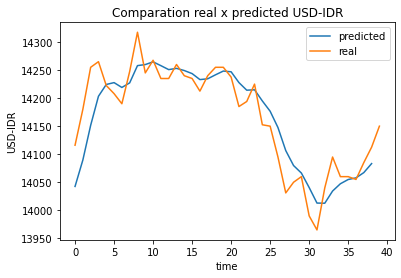

In [72]:
plt.plot(scaler_usd.inverse_transform(predicted['9_4'][1:40]))
plt.plot(scaler_usd.inverse_transform(data.usd.windows.y_test9[:40]))
plt.title('Comparation real x predicted USD-IDR')
plt.xlabel("time")
plt.ylabel("USD-IDR")
plt.legend(['predicted', 'real'], loc='upper right')
# plt.savefig()
plt.show()
# testpred = scaler.inverse_transform(testpred)
# Y_test = scaler.inverse_transform([Y_test])

# predictions = testpred

### Measurement

In [48]:
evaluations = []
for key, value in predicted.items():
    do_eval = Evaluation(
        x=scaler_usd.inverse_transform(
            data.usd.windows.__dict__[f"y_test{key.split('_')[0]}"]
        ),
        y=scaler_usd.inverse_transform(
            value
        )
    )
    evaluations.append({
            "key": key,
            "rmse": do_eval.rmse(),
            "mae": do_eval.mae(),
            "mda": do_eval.mda(),
        }
    )

In [49]:
pd.DataFrame(evaluations).sort_values('mae')

,key,rmse,mae,mda
9,9_2,105.764,57.256,0.500
5,8_2,108.016,59.415,0.499
7,8_4,116.342,63.252,0.501
2,7_3,116.328,63.568,0.497
11,9_4,113.230,64.477,0.489
6,8_3,112.715,65.582,0.501
8,9_1,130.743,71.835,0.500
15,10_4,132.672,74.295,0.499
3,7_4,131.810,74.675,0.497
12,10_1,131.816,74.753,0.521


### Results
Model dengan arsitektur 9-2-1 memiliki error paling kecil
- mae  : 57.256
- rmse : 105.764
- mda  : 50%

## 2 Hidden Layers
### Load models

In [67]:
predicted = {}
for neuron in neurons:
    model_file = f'./models/usd/model_9_2_{neuron}.h5'
    if os.path.exists(model_file):
        model = keras.models.load_model(model_file)
        print(f"Loaded model {model_file}...")
        predicted[f"9_2_{neuron}"] = model.predict(
            data.usd.windows.__dict__[f"X_test9"]
        )
        print(f"Predicted model {model_file}")

Loaded model ./models/usd/model_9_2_1.h5...
Predicted model ./models/usd/model_9_2_1.h5
Loaded model ./models/usd/model_9_2_2.h5...
Predicted model ./models/usd/model_9_2_2.h5
Loaded model ./models/usd/model_9_2_3.h5...
Predicted model ./models/usd/model_9_2_3.h5
Loaded model ./models/usd/model_9_2_4.h5...
Predicted model ./models/usd/model_9_2_4.h5


### Plotting predicted x actual

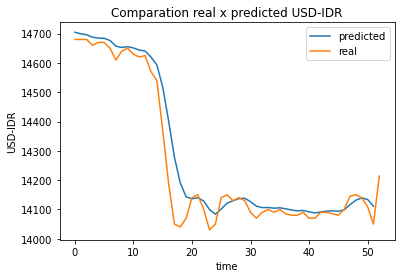

In [76]:
plt.plot(scaler_usd.inverse_transform(predicted['9_2_1'][301:]))
plt.plot(scaler_usd.inverse_transform(data.usd.windows.y_test9[300:]))
plt.title('Comparation real x predicted USD-IDR')
plt.xlabel("time")
plt.ylabel("USD-IDR")
plt.legend(['predicted', 'real'], loc='upper right')
# plt.savefig()
plt.show()

### Measurement

In [69]:
evaluations = []
for key, value in predicted.items():
    do_eval = Evaluation(
        x=scaler_usd.inverse_transform(
            data.usd.windows.__dict__[f"y_test{key.split('_')[0]}"]
        ),
        y=scaler_usd.inverse_transform(
            value
        )
    )
    evaluations.append({
            "key": key,
            "rmse": do_eval.rmse(),
            "mae": do_eval.mae(),
            "mda": do_eval.mda(),
        }
    )

In [70]:
pd.DataFrame(evaluations).sort_values('mae')

,key,rmse,mae,mda
0,9_2_1,144.030,82.177,0.506
2,9_2_3,146.361,82.742,0.500
3,9_2_4,164.874,91.717,0.503
1,9_2_2,203.684,116.428,0.517


### Results
Model dengan arsitektur 9-2-1-(1) memiliki error paling kecil
- mae  : 55.061
- rmse : 94.232
- mda  : 50%

In [79]:
data.usd.windows.X_test9.shape

(353, 9, 1)

## 3 Hidden Layers
### Load models

In [80]:
predicted = {}
for neuron in neurons:
    model_file = f'./models/usd/model_9_2_1_{neuron}.h5'
    if os.path.exists(model_file):
        model = keras.models.load_model(model_file)
        print(f"Loaded model {model_file}...")
        predicted[f"9_2_1_{neuron}"] = model.predict(
            data.usd.windows.__dict__[f"X_test9"])
        print(f"Predicted model {model_file}")
    else:
        print(f"model {model_file} not exists.")

Loaded model ./models/usd/model_9_2_1_1.h5...
Predicted model ./models/usd/model_9_2_1_1.h5
Loaded model ./models/usd/model_9_2_1_2.h5...
Predicted model ./models/usd/model_9_2_1_2.h5
Loaded model ./models/usd/model_9_2_1_3.h5...
Predicted model ./models/usd/model_9_2_1_3.h5
Loaded model ./models/usd/model_9_2_1_4.h5...
Predicted model ./models/usd/model_9_2_1_4.h5


### Plotting predicted x actual

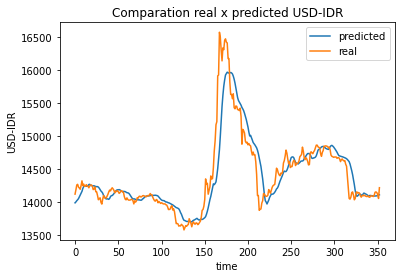

In [91]:
plt.plot(scaler_usd.inverse_transform(predicted['9_2_1_3']))
plt.plot(scaler_usd.inverse_transform(data.usd.windows.y_test9))
plt.title('Comparation real x predicted USD-IDR')
plt.xlabel("time")
plt.ylabel("USD-IDR")
plt.legend(['predicted', 'real'], loc='upper right')
# plt.savefig()
plt.show()

### Measurement

In [52]:
evaluations = []
for key, value in predicted.items():
    do_eval = Evaluation(
        x=scaler_usd.inverse_transform(
            data.usd.windows.__dict__[f"y_test{key.split('_')[0]}"]
        ),
        y=scaler_usd.inverse_transform(
            value
        )
    )
    evaluations.append({
            "key": key,
            "rmse": do_eval.rmse(),
            "mae": do_eval.mae(),
            "mda": do_eval.mda(),
        }
    )

In [35]:
pd.DataFrame(evaluations).sort_values('mae')

,key,rmse,mae,mda
0,9_2_1,94.232,55.061,0.500
1,9_2_2,107.210,60.982,0.494
2,9_2_3,145.911,80.811,0.486
3,9_2_4,208.396,117.967,0.523


### Results
Model dengan arsitektur 9-2-1-(1) memiliki error paling kecil
- mae  : 55.061
- rmse : 94.232
- mda  : 50%

# JPYIDR Model evaluation
---

In [50]:
neurons = [1,2,3,4]
inputs = [7,8,9,10]
n_layer = 3

## First Layer
- Load model 

In [51]:
data.jpy.windows.__dict__["X_test7"].shape

(359, 7, 1)

In [52]:
# predicted = {}
# for slide in inputs:
#     for neuron in neurons:
#         model_file = f'./models/jpy/model_{slide}_{neuron}.h5'
#         if os.path.exists(model_file):
#             model = keras.models.load_model(model_file)
#             print(f"Loaded model {slide}_{neuron} from storage...")
#             predicted[f"{slide}_{neuron}"] = model.predict(
#                 data.jpy.windows.__dict__[f"X_test{slide}"]
#             )
#             print(f"Predicted model {slide}_{neuron}")
#         break
#     break